# AUTOML - projekt 2

In [1]:
#pip install lightgbm
#!pip install xgboost
#!pip install catboost


In [2]:
import json
import numpy as np
import importlib
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

# MiniAutoML

In [3]:

class MiniAutoML:
    def __init__(self, models_config, max_models=None, seed = 42):

        self.all_models_config = models_config  # konfiguracja modeli -> wczytana z pliku json
        self.max_models = max_models            # ile modeli sprawdzić (None = wszystkie)

        self.random_state = seed
        self.selected_models_ = []
        self.pipelines_ = []

    def _load_model_class(self, class_path):

        " funkcja pomocnicza wyciągająca rodzaj modelu z pliku json i ładująca go z biblioteki"

        module_name, class_name = class_path.rsplit(".", 1)
        module = importlib.import_module(module_name)
        return getattr(module, class_name)

    def _build_pipeline(self, model):
        " preprocessing + model "

        numeric_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),  # wybralam mediane, bo jest najbardziej stabilna, szybka i odporna na outliery
            ("scaler", StandardScaler())                     # skalowanie poprawia dzialanie modeli liniowych i SVM
        ])

        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, self.numeric_features_),
                ("cat", categorical_transformer, self.categorical_features_)
            ]
        )

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ])

        return pipeline

    def fit(self, X_train, y_train, fast_mode=False):

        # upewniamy sie, ze y ma poprawny ksztalt (1D)
        y_train = np.ravel(y_train)

        self.numeric_features_ = X_train.select_dtypes(include=["int64", "float64"]).columns
        self.categorical_features_ = X_train.select_dtypes(exclude=["int64", "float64"]).columns

        if self.max_models is not None:
            models_to_check = self.all_models_config[:self.max_models]
        else:
            models_to_check = self.all_models_config

        print(f"Sprawdzam {len(models_to_check)} modeli...")

        cv = StratifiedKFold(
            n_splits=3 if fast_mode else 5,  # fast_mode = szybsze testy
            shuffle=True,
            random_state=self.random_state
        )

        scores = []

        for cfg in tqdm(models_to_check, desc="Selekcja modeli"):
            ModelClass = self._load_model_class(cfg["class"])
            model = ModelClass(**cfg.get("params", {}))

            pipeline = self._build_pipeline(model)

            cv_scores = cross_val_score(
                pipeline,
                X_train,
                y_train,
                cv=cv,
                scoring="balanced_accuracy",
                n_jobs=-1
            )

            scores.append({
                "name": cfg["name"],
                "pipeline": pipeline,
                "score": np.mean(cv_scores)
            })

        scores = sorted(scores, key=lambda x: x["score"], reverse=True)  # sortujemy modele wg balanced accuracy

        max_ensemble_size = 5
        top_models = scores[:max_ensemble_size]  # wybór top 5 modeli
 
        print("\nRanking modeli (Top 5):")
        for i, item in enumerate(top_models, 1):
            print(f"{i}. {item['name']} - CV score: {item['score']:.3f}")

        # Zapisanie wyników do późniejszego porównania
        self.history_ = [
            {"model": item["name"], "score": item["score"]}
            for item in scores
        ]
        
        self.top5_ = self.history_[:5]
        self.best_score_ = self.top5_[0]["score"]
        self.best_model_name_ = self.top5_[0]["model"]
        
        self.pipelines_ = []
        for item in top_models:
            pipe = item["pipeline"]
            pipe.fit(X_train, y_train)  # trenowanie wybranych modeli na calym zbiorze treningowym
            self.pipelines_.append(pipe)

        return self

    def predict_proba(self, X_test):
        probs = []

        for pipe in self.pipelines_:
            p = pipe.predict_proba(X_test)[:, 1]  # prawdopodobienstwo klasy pozytywnej
            probs.append(p)

        probs = np.vstack(probs)
        return np.mean(probs, axis=0)  # soft voting (ensemble)

    def predict(self, X_test):
        proba = self.predict_proba(X_test)
        return (proba >= 0.5).astype(int)


# Test na ramce z zajęć

In [4]:
with open("models.json") as f:
    models_config = json.load(f)

X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# automl = MiniAutoML(models_config)
# automl.fit(X_train, y_train)

In [6]:
# automl = MiniAutoML(models_config, max_models=5)
# automl.fit(X_train, y_train, fast_mode=True)

In [7]:
# X_small = X_train.sample(500, random_state=42)
# y_small = y_train.loc[X_small.index]

# automl = MiniAutoML(models_config, max_models=5)
# automl.fit(X_small, y_small, fast_mode=True)

# Test na innych ramkach


In [8]:
df_raisins = pd.read_csv("Raisin_Dataset.csv")
df_med = pd.read_csv("Surgical-deepnet.csv")
df_income = pd.read_csv("train.csv")

In [9]:
def prepare_binary_dataset(df, target, mapping):
    df = df.dropna(subset=[target]).copy()
    df[target] = df[target].map(mapping)

    X = df.drop(columns=[target])
    y = df[target]

    return X, y

In [10]:
X1, y1 = prepare_binary_dataset(
    df_raisins,
    target='Class',
    mapping={'Kecimen': True, 'Besni': False}
)

X2, y2 = prepare_binary_dataset(
    df_med,
    target='mort30',
    mapping={1: True, 0: False}
)

X3, y3 = prepare_binary_dataset(
    df_income,
    target='income_>50K',
    mapping={1: True, 0: False}
)


In [11]:
datasets = {
    "raisins_class": (X1, y1),
    "med_mort30": (X2, y2),
    "income_50k": (X3, y3),
}

# Sprawdzenie stabilności na różnych ziarnach

### Obliczenia przeprowadze dla każdego zbioru oddzielnie ze względu na długi czas wykonywania

In [12]:
def run_automl_ensemble(X, y, name, models_config, test_size=0.2, seed=42):
    print(f"\nRunning AutoML for: {name}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=seed,
        stratify=y
    )

    automl = MiniAutoML(models_config, seed=seed)
    automl.fit(X_train, y_train)

    return automl, X_test, y_test


In [13]:
results_5_seeds = {}
seeds = [0, 42, 123, 2023, 999]

In [14]:
# name, (X, y) = "raisins_class", datasets["raisins_class"]

# results_5_seeds[name] = {}

# for seed in seeds:
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)
    
#     y_pred_ensemble = automl.predict(X_test)  # ensemble
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)
    
#     results_5_seeds[name][seed] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [15]:
# name, (X, y) = "med_mort30", datasets["med_mort30"]

# results_5_seeds[name] = {}


# for seed in seeds:
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)
    
#     y_pred_ensemble = automl.predict(X_test)  # ensemble
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)
    
#     results_5_seeds[name][seed] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [16]:
# name, (X, y) = "income_50k", datasets["income_50k"]

# results_5_seeds[name] = {}

# for seed in seeds:
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)
    
#     y_pred_ensemble = automl.predict(X_test)  # ensemble
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)
    
#     results_5_seeds[name][seed] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [17]:
# rows = []

# for dataset, run_dict in results_5_seeds.items():
#     for seed, res in run_dict.items():
#         automl = res["automl"]
#         ensemble_score = res["ensemble_score"]

#         for rank, item in enumerate(automl.top5_, 1):
#             rows.append({
#                 "dataset": dataset,
#                 "seed": seed,
#                 "rank": rank,
#                 "model": item["model"],      # wyciągamy nazwę z słownika
#                 "cv_score": item["score"],   # wyciągamy wynik CV z słownika 
#                 "ensemble_score": ensemble_score
#             })

# df_5_seeds = pd.DataFrame(rows)


In [18]:
# df_5_seeds = pd.DataFrame(rows)
# df_5_seeds.to_csv("df_5_seeds.csv", index=False)

# df_5_seeds.head(6)

Dla zbioru danych income system przetestowany został dla tylko 4 ziaren losowości ze względu na długi czas oczekiwania

In [19]:
df_5_seeds = pd.read_csv("df_5_seeds.csv")

In [20]:
df_5_seeds.head(4)

,dataset,seed,rank,model,cv_score,ensemble_score
0,raisins_class,0,1,svc_rbf_standard,0.865278,0.894444
1,raisins_class,0,2,lgbm_200_extra_trees,0.862500,0.894444
2,raisins_class,0,3,svc_rbf_loose,0.862500,0.894444
3,raisins_class,0,4,svc_rbf_tight,0.862500,0.894444


# Sprawdzenie powtarzalności na jednym ziarnie

### Obliczenia przeprowadze dla każdego zbioru oddzielnie ze względu na długi czas wykonywania

In [21]:
# results_one_seed = {}
# seed = 42

In [22]:
# name, (X, y) = "raisins_class", datasets["raisins_class"]

# results_one_seed[name] = {}

# for run_id in range(5):
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)

#     y_pred_ensemble = automl.predict(X_test)  # ensemble
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)

#     results_one_seed[name][run_id] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [23]:
# name, (X, y) = "med_mort30", datasets["med_mort30"]

# results_one_seed[name] = {}

# for run_id in range(5):
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)

#     y_pred_ensemble = automl.predict(X_test)
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)

#     results_one_seed[name][run_id] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [24]:
# name, (X, y) = "income_50k", datasets["income_50k"]

# results_one_seed[name] = {}

# for run_id in range(5):
#     automl, X_test, y_test = run_automl_ensemble(X, y, name, models_config, seed=seed)

#     y_pred_ensemble = automl.predict(X_test)
#     ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)

#     results_one_seed[name][run_id] = {
#         "automl": automl,
#         "ensemble_score": ensemble_score
#     }


In [25]:
# rows = []

# for dataset, run_dict in results_one_seed.items():
#     for run_id, res in run_dict.items():
#         automl = res["automl"]
#         ensemble_score = res["ensemble_score"]

#         for rank, item in enumerate(automl.top5_, 1):
#             rows.append({
#                 "dataset": dataset,
#                 "run_id": run_id,
#                 "rank": rank,
#                 "model": item["model"],      # wyciągamy nazwę z słownika
#                 "cv_score": item["score"],   # wyciągamy wynik CV z słownika
#                 "ensemble_score": ensemble_score
#             })

# df_one_seed = pd.DataFrame(rows)


In [26]:
# df_one_seed.to_csv("df_one_seed2.csv", index=False)


In [27]:
df_one_seed = pd.read_csv("df_one_seed.csv")

In [28]:
df_one_seed[df_one_seed['dataset'] == 'med_mort30'].head(5)

,dataset,run_id,rank,model,cv_score,ensemble_score
25,med_mort30,0,1,svc_linear,0.827862,0.810006
26,med_mort30,0,2,logreg_l2_standard,0.823221,0.810006
27,med_mort30,0,3,logreg_l1_selection,0.823221,0.810006
28,med_mort30,0,4,logreg_l2_strong,0.822535,0.810006
29,med_mort30,0,5,lgbm_300_dart_slow,0.773948,0.810006


# Analiza wyników

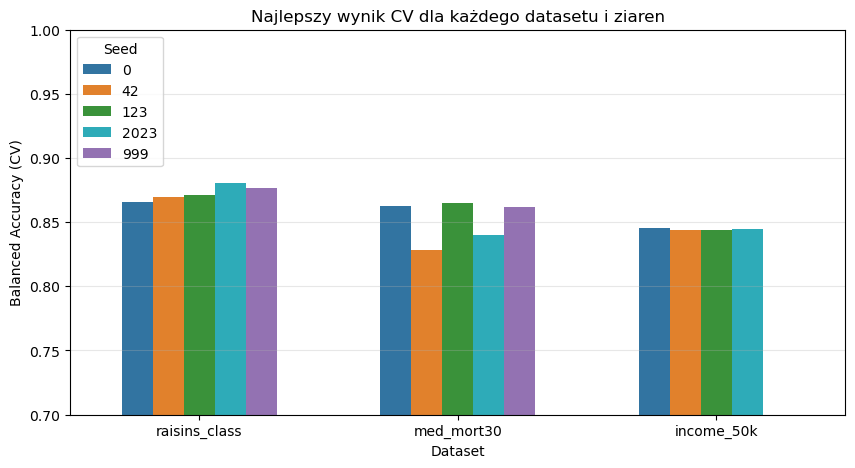

In [29]:
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#17becf", "#9467bd"]

best_per_seed = df_5_seeds[df_5_seeds["rank"] == 1].copy()

# ziarna jako kategorie
best_per_seed["seed"] = best_per_seed["seed"].astype(str)

plt.figure(figsize=(10, 5))

sns.barplot(
    data=best_per_seed,
    x="dataset",
    y="cv_score",
    hue="seed",
    width=0.6,
    palette=custom_colors
)

plt.title("Najlepszy wynik CV dla każdego datasetu i ziaren")
plt.ylabel("Balanced Accuracy (CV)")
plt.xlabel("Dataset")
plt.ylim(0.7, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Seed")
plt.show()


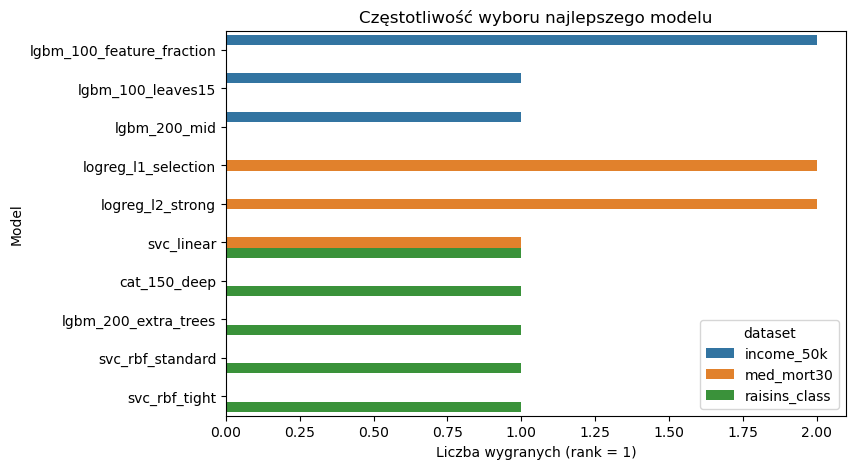

In [30]:
model_frequency = (
    best_per_seed
    .groupby(["dataset", "model"])
    .size()
    .reset_index(name="count")
    .sort_values(["dataset", "count"], ascending=[True, False])
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=model_frequency,
    x="count",
    y="model",
    hue="dataset"
)
plt.title("Częstotliwość wyboru najlepszego modelu")
plt.xlabel("Liczba wygranych (rank = 1)")
plt.ylabel("Model")
plt.show()


In [31]:
cv_vs_ensemble = (
    df_5_seeds
    .groupby(["dataset", "seed"])
    .agg(
        best_cv=("cv_score", "max"),
        ensemble_score=("ensemble_score", "first")
    )
    .reset_index()
)


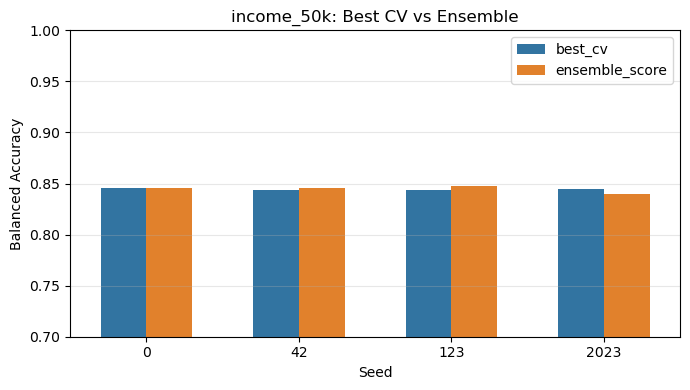

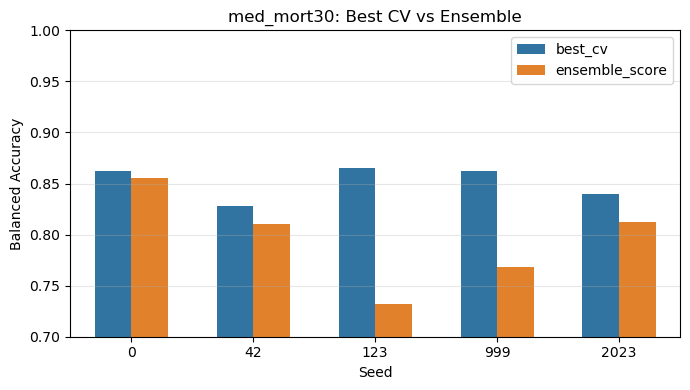

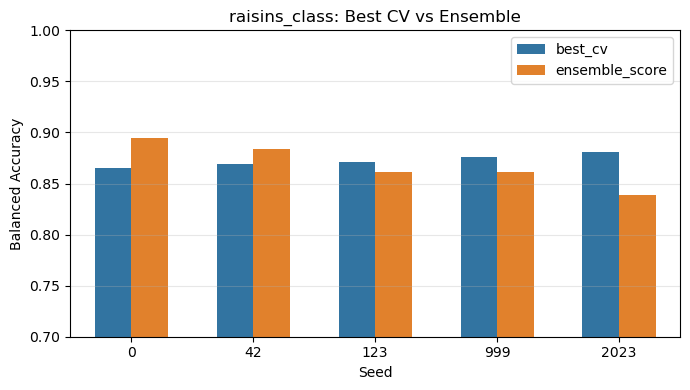

In [32]:
datasets = cv_vs_ensemble["dataset"].unique()

for ds in datasets:
    plot_df = cv_vs_ensemble[cv_vs_ensemble["dataset"] == ds]

    # usuwam ziarno 999 tylko dla income bo się nie doliczyło
    if ds == "income_50K":
        plot_df = plot_df[plot_df["seed"] != 999]

    plot_df = plot_df.melt(
        id_vars="seed",
        value_vars=["best_cv", "ensemble_score"],
        var_name="type",
        value_name="score"
    )

    plt.figure(figsize=(7, 4))

    sns.barplot(
        data=plot_df,
        x="seed",
        y="score",
        hue="type",
        width=0.6
    )

    plt.title(f"{ds}: Best CV vs Ensemble")
    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Seed")
    plt.ylim(0.7, 1.0)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()


# Ewaluacja na zajęciach

In [33]:
# X_eval = pd.read_csv("file_name_X.csv")
# y_eval = pd.read_csv("file_name_y.csv")

# X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.2, random_state=42, stratify=y)

In [34]:
# automl.fit(X_train, y_train)

In [35]:
# y_pred_ensemble = automl.predict(X_test)
# ensemble_score = balanced_accuracy_score(y_test, y_pred_ensemble)